In [1]:
from pathlib import Path

import pandas as pd
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import MDAnalysis as mda

import scipy.stats

In [2]:
import bioemu

In [3]:
from bioemu import observables_ddr as observables

/oak/stanford/groups/rondror/users/ddrichma/2025/finetune-bioemu/SE3Diff/bioemu/src/bioemu/observables_ddr.py:211: SyntaxWarning: invalid escape sequence '\m'
  q = \frac{1}{N_\mathrm{contacts}} \sum_{c}^{N_\mathrm{contacts}} \frac{1}{1 + \exp(-\beta(d_c - \lambda (d^\mathrm{ref}_c + \delta)))}
/scratch/users/ddrichma/micromamba/envs/mamba250530-bioemu-ft/lib/python3.12/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [4]:
observables.compute_h_for_grb2_sh3

<function bioemu.observables_ddr.compute_h_for_grb2_sh3(pos: torch.Tensor, node_orientations: torch.Tensor, ref_path: str) -> torch.Tensor>

In [5]:
def extract_ca_coordinates(pdb_file, xtc_file, frame_step=50):
    """
    Extract carbon alpha coordinates from every nth frame of a trajectory.
    
    Parameters:
    -----------
    pdb_file : str
        Path to the PDB file (topology)
    xtc_file : str
        Path to the XTC file (trajectory)
    frame_step : int, default=50
        Extract coordinates from every nth frame
    
    Returns:
    --------
    ca_coords : numpy.ndarray
        Array of shape (n_frames, n_ca_atoms, 3) containing CA coordinates
    frame_indices : list
        List of frame indices that were extracted
    """
    
    # Load the trajectory
    u = mda.Universe(pdb_file, xtc_file)
    
    # Select carbon alpha atoms
    ca_atoms = u.select_atoms('name CA')
    
    print(f"Total frames in trajectory: {len(u.trajectory)}")
    print(f"Number of CA atoms: {len(ca_atoms)}")
    print(f"Extracting every {frame_step}th frame")
    
    # Calculate which frames to extract
    frame_indices = list(range(0, len(u.trajectory), frame_step))
    n_frames = len(frame_indices)
    n_ca_atoms = len(ca_atoms)
    
    # Initialize array to store coordinates
    ca_coords = np.zeros((n_frames, n_ca_atoms, 3))
    
    # Extract coordinates from selected frames
    for i, frame_idx in enumerate(frame_indices):
        u.trajectory[frame_idx]  # Move to specific frame
        ca_coords[i] = ca_atoms.positions  # Extract CA positions
        
        if i % 10 == 0:  # Progress indicator
            print(f"Processed frame {i+1}/{n_frames} (trajectory frame {frame_idx})")
    
    print(f"Extraction complete. Shape of coordinate array: {ca_coords.shape}")
    
    return ca_coords, frame_indices

# Quick check of wild type protein

In [6]:
!ls ../../conformations-md/grb2-sh3/wt/charmm-gui-4854614049/openmm/

combined_step5.dcd	 step5_140.dcd	step5_188.out  step5_53.rst
omm_barostat.py		 step5_140.out	step5_188.rst  step5_54.dcd
omm_readinputs.py	 step5_140.rst	step5_189.dcd  step5_54.out
omm_readinputs.pyc	 step5_141.dcd	step5_189.out  step5_54.rst
omm_readparams.py	 step5_141.out	step5_189.rst  step5_55.dcd
omm_restraints.py	 step5_141.rst	step5_18.dcd   step5_55.out
omm_rewrap.py		 step5_142.dcd	step5_18.out   step5_55.rst
omm_step3_input.psf	 step5_142.out	step5_18.rst   step5_56.dcd
omm_vfswitch.py		 step5_142.rst	step5_190.dcd  step5_56.out
openmm_run.py		 step5_143.dcd	step5_190.out  step5_56.rst
orig_step3_input.psf	 step5_143.out	step5_190.rst  step5_57.dcd
README			 step5_143.rst	step5_191.dcd  step5_57.out
README2			 step5_144.dcd	step5_191.out  step5_57.rst
rename.err		 step5_144.out	step5_191.rst  step5_58.dcd
rename.out		 step5_144.rst	step5_192.dcd  step5_58.out
restraints		 step5_145.dcd	step5_192.out  step5_58.rst
step3_input.parm7	 step5_145.out	step5_192.rst  step5_59.dcd

In [7]:
md_frames, _ = extract_ca_coordinates('../../conformations-md/grb2-sh3/G45H/charmm-gui-4851179166/openmm/step3_input.pdb',
                                    '../../conformations-md/grb2-sh3/G45H/charmm-gui-4851179166//openmm/combined_step5.dcd',
                                    frame_step=10)

md_frames = md_frames / 10 # nm to A

Total frames in trajectory: 2000
Number of CA atoms: 56
Extracting every 10th frame
Processed frame 1/200 (trajectory frame 0)
Processed frame 11/200 (trajectory frame 100)
Processed frame 21/200 (trajectory frame 200)
Processed frame 31/200 (trajectory frame 300)
Processed frame 41/200 (trajectory frame 400)
Processed frame 51/200 (trajectory frame 500)
Processed frame 61/200 (trajectory frame 600)
Processed frame 71/200 (trajectory frame 700)
Processed frame 81/200 (trajectory frame 800)
Processed frame 91/200 (trajectory frame 900)
Processed frame 101/200 (trajectory frame 1000)
Processed frame 111/200 (trajectory frame 1100)
Processed frame 121/200 (trajectory frame 1200)
Processed frame 131/200 (trajectory frame 1300)
Processed frame 141/200 (trajectory frame 1400)
Processed frame 151/200 (trajectory frame 1500)
Processed frame 161/200 (trajectory frame 1600)
Processed frame 171/200 (trajectory frame 1700)
Processed frame 181/200 (trajectory frame 1800)
Processed frame 191/200 (tr

/scratch/users/ddrichma/micromamba/envs/mamba250530-bioemu-ft/lib/python3.12/site-packages/MDAnalysis/topology/PDBParser.py:346: UserWarning: Unknown element DU found for some atoms. These have been given an empty element record. If needed they can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn(wmsg)
/scratch/users/ddrichma/micromamba/envs/mamba250530-bioemu-ft/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


In [8]:
h = observables.compute_h_for_grb2_sh3_raw(torch.tensor(md_frames).type(torch.float32), torch.zeros((1,1,1,1)), "structures/2vwf_trimmed_SH3.pdb")

tensor([[-1.0728,  1.1141,  0.4442],
        [-0.4816,  0.8361,  0.4734],
        [ 0.2659,  0.2529,  0.2310],
        [ 0.5677,  0.4103,  0.0349],
        [ 0.3929,  0.9887,  0.1182],
        [ 0.0086,  1.7342, -1.0905],
        [-0.3254,  1.3718, -0.8630],
        [-0.0360,  1.4206, -0.6094],
        [ 0.3573,  1.8452, -0.2042],
        [ 0.3769,  1.4503, -0.1611],
        [-0.2772,  1.2133, -0.2638],
        [-0.8516,  1.2691, -0.3743],
        [-0.8069,  1.2719,  0.0051]]) tensor([[-0.9978,  1.0783,  0.4998],
        [-0.4135,  0.8576,  0.4682],
        [ 0.2824,  0.3048,  0.2305],
        [ 0.5921,  0.4418,  0.0479],
        [ 0.3954,  0.9737,  0.1358],
        [ 0.0818,  1.7404, -1.0438],
        [-0.3077,  1.3683, -0.9147],
        [-0.0718,  1.3894, -0.6184],
        [ 0.2900,  1.7750, -0.1980],
        [ 0.2855,  1.3707, -0.1119],
        [-0.3576,  1.2204, -0.3421],
        [-0.8679,  1.3664, -0.3901],
        [-0.7932,  1.2919, -0.0227]])


(array([ 4., 34., 30., 10., 45., 38., 20., 10.,  4.,  5.]),
 array([0.04646162, 0.06851069, 0.09055976, 0.11260882, 0.13465789,
        0.15670696, 0.17875603, 0.2008051 , 0.22285417, 0.24490324,
        0.26695231]),
 <BarContainer object of 10 artists>)

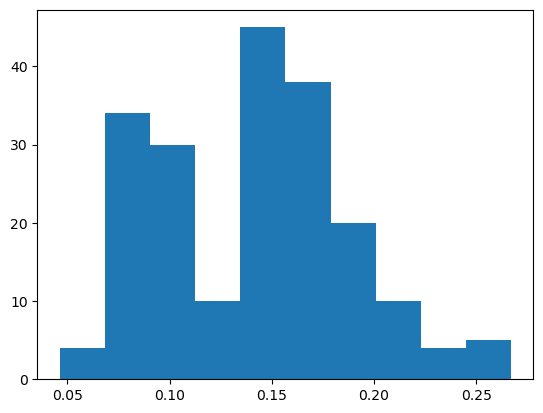

In [9]:
plt.hist(h[:, 1])

Text(0.5, 1.0, 'SH3 domain MD simulation frames')

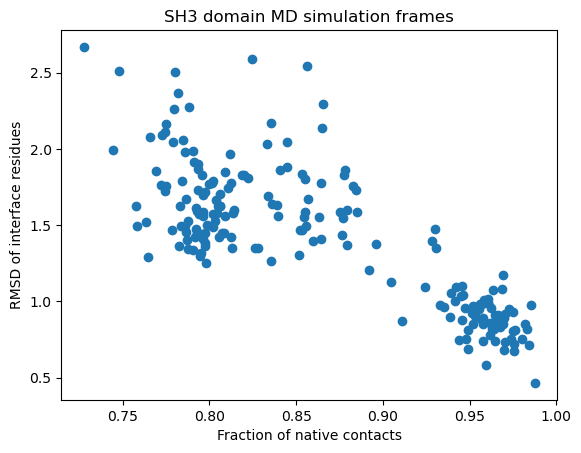

In [13]:
plt.scatter(h[:,0], h[:,1] * 10)
plt.xlabel('Fraction of native contacts')
plt.ylabel('RMSD of interface residues')
plt.title('SH3 domain MD simulation frames')

# Plot non-ft BioEmu results for many mutants

In [11]:
records = []
for mutation_dir in Path('../../bioemu-testing/protein_results/grb2-sh3/test0/').glob('*'):
    mutation_name = mutation_dir.name
    print(mutation_name)
    _, pos, orientations = read_dir(mutation_dir)
    h = observables.compute_h_for_grb2_sh3(pos, orientations, "structures/2vwf_trimmed_SH3.pdb")

    # rough proxy for dg_binding
    h_folded, h_bindable = h[:, 0], h[:, 1]
    dg_folding = -np.log((h_folded == 1).sum() / (h_folded == 0).sum()).item()
    dg_binding = -np.log((h_bindable == 1).sum() / (h_bindable == 0).sum()).item()

    # bootstrapping for error estimates
    bootstrap_dg_f = [-np.log((np.random.choice(h_folded, len(h_folded)) == 1).sum() / (np.random.choice(h_folded, len(h_folded)) == 0).sum()) for _ in range(1000)]
    bootstrap_dg_b = [-np.log((np.random.choice(h_bindable, len(h_bindable)) == 1).sum() / (np.random.choice(h_bindable, len(h_bindable)) == 0).sum()) for _ in range(1000)]

    dg_folding_err, dg_binding_err = np.std(bootstrap_dg_f), np.std(bootstrap_dg_b)
    
    records.append((mutation_name, dg_folding, dg_binding, dg_folding_err, dg_binding_err))

F19I


NameError: name 'read_dir' is not defined

In [10]:
h[:,0]

tensor([1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 

<Axes: ylabel='Count'>

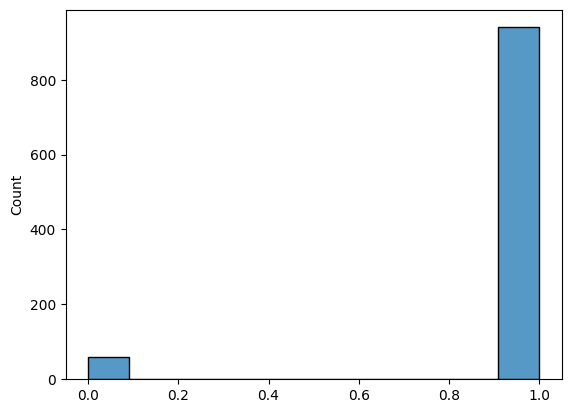

In [11]:
sns.histplot(h[:,0])

In [12]:
records

[('F19I',
  -2.4288370609283447,
  -2.05051851272583,
  0.10460562194181541,
  0.09057910400144063),
 ('F19L',
  -2.277543067932129,
  -1.8746898174285889,
  0.10090690493044342,
  0.08112936516630292),
 ('L6I',
  -3.009467363357544,
  -2.5268092155456543,
  0.1474827577732704,
  0.11329019358489704),
 ('wt',
  -2.751535415649414,
  -2.26574444770813,
  0.12617136981521332,
  0.1000791192657743),
 ('T53G',
  -2.2894558906555176,
  -1.9367984533309937,
  0.10102037322291182,
  0.08428093353237903),
 ('H26T',
  -2.4423470497131348,
  -2.1428632736206055,
  0.10803686451161275,
  0.0916119559896266),
 ('W36K',
  -1.2598483562469482,
  -0.9643905758857727,
  0.06263236407719999,
  0.05522643812025393),
 ('P11L',
  -2.6995484828948975,
  -2.001934051513672,
  0.12255845799052682,
  0.08662733738134411),
 ('D32F',
  -2.7339415550231934,
  -2.208385467529297,
  0.12547173187754285,
  0.10223064872749257),
 ('M28Y',
  -2.483823776245117,
  -2.0907411575317383,
  0.11285893399015705,
  0.090302

In [13]:
bioemu_non_ft_predictions = pd.DataFrame.from_records(records, columns=['id', 'dg_folding_est', 'dg_binding_est', 'dg_folding_err', 'dg_binding_err'])

# Adjust to ddgs. What we're estimating here is really something like a dg from "bindable" to nonbindable
# which can be viewed as a ddg of binding
#wt_est = bioemu_non_ft_predictions.loc[bioemu_non_ft_predictions['id'] == 'wt', 'dg_binding_est'].item()
#bioemu_non_ft_predictions['ddg_binding_est'] -= wt_est
# for purposes of h* it's easier just to stick with dg

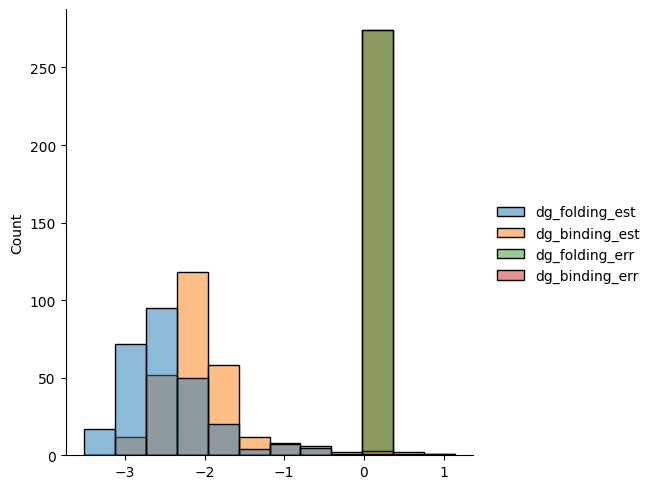

In [14]:
sns.displot(bioemu_non_ft_predictions)

# Compare to ground truth

In [15]:
gt_data = pd.read_csv('reference_h/GRB2_SH3_high_confidence.csv')
gt_data.loc[gt_data.id == '-0-', 'id'] = 'wt' # rename wt row

In [16]:
combined_df = gt_data.merge(bioemu_non_ft_predictions)

In [17]:
combined_df.columns

Index(['Pos_ref', 'id', 'id_ref', 'Pos', 'mut_order', 'f_dg_pred',
       'f_ddg_pred', 'f_ddg_pred_sd', 'b_dg_pred', 'b_ddg_pred',
       'b_ddg_pred_sd', 'f_ddg_pred_conf', 'b_ddg_pred_conf', 'HAmin_ligand',
       'scHAmin_ligand', 'RSASA', 'SS', 'Pos_class', 'protein', 'WT_AA', 'Mut',
       'b_ddg_wposmeanabs', 'b_ddg_wposse', 'allosteric', 'orthosteric',
       'allosteric_mutation', 'seq', 'prob_folded', 'prob_bound',
       'dg_folding_est', 'dg_binding_est', 'dg_folding_err', 'dg_binding_err'],
      dtype='object')

In [18]:
combined_df.loc[combined_df.id=='wt', 'Pos_class'] = 'wt'

Text(0.5, 28.999999999999986, 'Estimated $\\Delta G_{fold}$ from BioEmu')

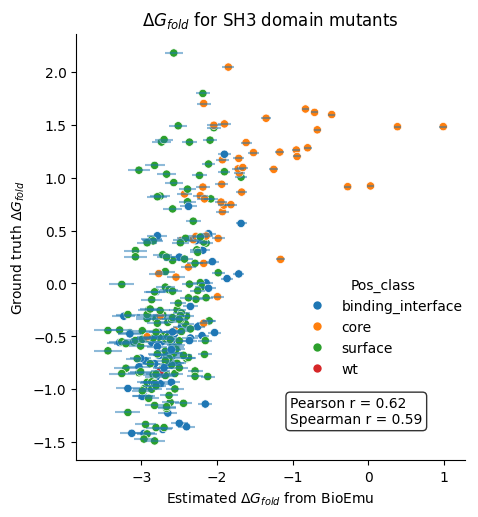

In [19]:
g = sns.relplot(combined_df, y='f_dg_pred', x='dg_folding_est', hue='Pos_class')
sns.move_legend(g, loc='lower right', bbox_to_anchor=(.75, .26))
g.ax.errorbar(combined_df['dg_folding_est'], combined_df['f_dg_pred'], xerr=combined_df['dg_folding_err'], fmt='none', alpha=0.5)
pearson_r = scipy.stats.pearsonr(combined_df['f_dg_pred'], combined_df['dg_folding_est'])[0]
spearman_r = scipy.stats.spearmanr(combined_df['f_dg_pred'], combined_df['dg_folding_est'])[0]
g.ax.text(0.55, 0.15, f'Pearson r = {pearson_r:.2f}\nSpearman r = {spearman_r:.2f}', transform=g.ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.title(r'$\Delta G_{fold}$ for SH3 domain mutants')
plt.ylabel(r'Ground truth $\Delta G_{fold}$')
plt.xlabel(r'Estimated $\Delta G_{fold}$ from BioEmu')

In [20]:
for c in set(combined_df['Pos_class']):
    df_subset = combined_df[combined_df['Pos_class'] == c]
    print(c, scipy.stats.spearmanr(df_subset.f_ddg_pred, df_subset.dg_folding_est))

surface SignificanceResult(statistic=0.3672815913241005, pvalue=2.226620644810021e-06)
binding_interface SignificanceResult(statistic=0.5307723679902361, pvalue=2.1641598403444836e-05)
wt SignificanceResult(statistic=nan, pvalue=nan)
core SignificanceResult(statistic=0.6948733391420449, pvalue=2.1632227086809718e-08)


In [1]:

g = sns.relplot(combined_df, y='b_dg_pred', x='dg_binding_est', hue='Pos_class', legend=False)
#sns.move_legend(g, 'upper right', bbox_to_anchor=(.75, .97))
g.ax.errorbar( combined_df['dg_binding_est'], combined_df['b_dg_pred'], xerr=combined_df['dg_binding_err'], fmt='none', alpha=0.5)
pearson_r = scipy.stats.pearsonr(combined_df['b_dg_pred'], combined_df['dg_binding_est'])[0]
spearman_r = scipy.stats.spearmanr(combined_df['b_dg_pred'], combined_df['dg_binding_est'])[0]
g.ax.text(0.55, 0.15, f'Pearson r = {pearson_r:.2f}\nSpearman r = {spearman_r:.2f}', transform=g.ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.title(r'$\Delta \Delta G_{bind}$ for SH3 domain mutants')
plt.ylabel(r'Ground truth $\Delta G_{bind}$')
plt.xlabel(r'Estimated $\Delta \Delta G_{bind}$ from BioEmu')

NameError: name 'sns' is not defined

In [22]:
set(combined_df[combined_df['Pos_class'] == 'binding_interface'].Pos)

{7.0, 9.0, 12.0, 13.0, 16.0, 32.0, 34.0, 35.0, 37.0, 46.0, 48.0, 50.0, 51.0}

Text(0.5, 9.444444444444438, 'Estimated $\\Delta G_{bind}$ from BioEmu')

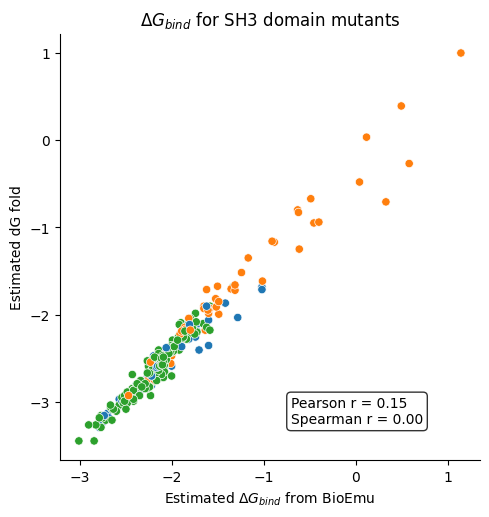

In [23]:

g = sns.relplot(combined_df, y='dg_folding_est', x='dg_binding_est', hue='Pos_class', legend=False)
#sns.move_legend(g, 'upper right', bbox_to_anchor=(.75, .97))
g.ax.text(0.55, 0.15, f'Pearson r = {pearson_r:.2f}\nSpearman r = {spearman_r:.2f}', transform=g.ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.title(r'$\Delta G_{bind}$ for SH3 domain mutants')
plt.ylabel(r'Estimated dG fold')
plt.xlabel(r'Estimated $\Delta G_{bind}$ from BioEmu')

Text(0.5, 9.444444444444438, 'Measured $\\Delta G_{bind}$')

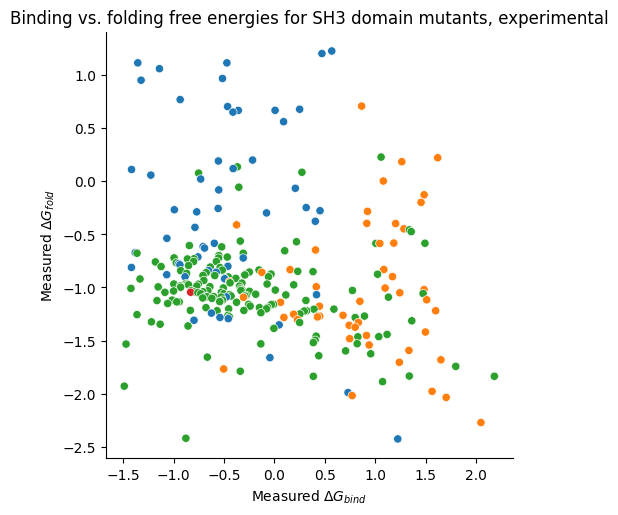

In [31]:

g = sns.relplot(combined_df, y='b_dg_pred', x='f_dg_pred', hue='Pos_class', legend=False)
#sns.move_legend(g, 'upper right', bbox_to_anchor=(.75, .97))
plt.title(r'Binding vs. folding free energies for SH3 domain mutants, experimental')
plt.ylabel(r'Measured $\Delta G_{fold}$')
plt.xlabel(r'Measured $\Delta G_{bind}$')

Text(0.5, 28.999999999999986, 'Estimated $\\Delta G_{bind}$ from BioEmu')

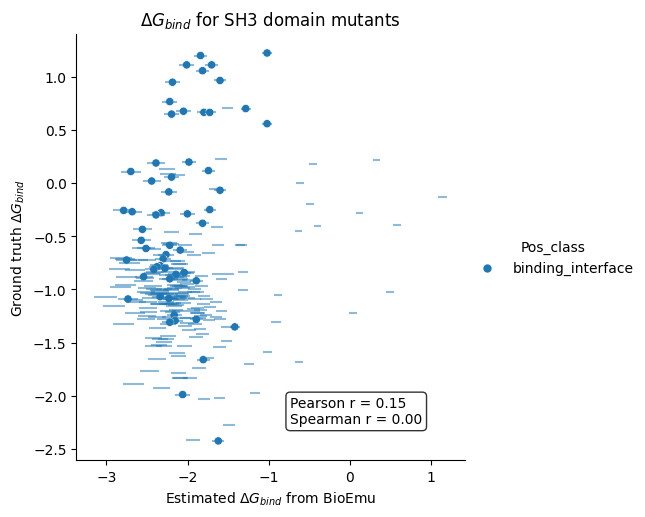

In [24]:

g = sns.relplot(combined_df[combined_df.Pos_class == 'binding_interface'], y='b_dg_pred', x='dg_binding_est', hue='Pos_class')
#sns.move_legend(g, 'upper right')
g.ax.errorbar( combined_df['dg_binding_est'], combined_df['b_dg_pred'], xerr=combined_df['dg_binding_err'], fmt='none', alpha=0.5)
pearson_r = scipy.stats.pearsonr(combined_df['b_dg_pred'], combined_df['dg_binding_est'])[0]
spearman_r = scipy.stats.spearmanr(combined_df['b_dg_pred'], combined_df['dg_binding_est'])[0]
g.ax.text(0.55, 0.15, f'Pearson r = {pearson_r:.2f}\nSpearman r = {spearman_r:.2f}', transform=g.ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.title(r'$\Delta G_{bind}$ for SH3 domain mutants')
plt.ylabel(r'Ground truth $\Delta G_{bind}$')
plt.xlabel(r'Estimated $\Delta G_{bind}$ from BioEmu')

In [25]:
scipy.stats.spearmanr(combined_df.b_ddg_pred, combined_df.dg_binding_est)

SignificanceResult(statistic=0.0035581588993540652, pvalue=0.9540282199493275)

In [26]:
for c in set(combined_df['Pos_class']):
    df_subset = combined_df[combined_df['Pos_class'] == c]
    print(c, scipy.stats.spearmanr(df_subset.b_ddg_pred, df_subset.dg_binding_est))

surface SignificanceResult(statistic=-0.05730896371173037, pvalue=0.4758907847612509)
binding_interface SignificanceResult(statistic=0.26126141968120925, pvalue=0.0496435960131398)
wt SignificanceResult(statistic=nan, pvalue=nan)
core SignificanceResult(statistic=0.35951495036404374, pvalue=0.010340741220210607)


# test h_star code

In [27]:
observables.h_star_for_grb2_sh3('reference_h/GRB2_SH3_high_confidence.csv')

(0      TYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTHM...
 1      TYVQALFDCDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...
 2      TYVQALFDVDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...
 3      TYVQALIDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...
 4      TYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNRWKGACHGQTGM...
                              ...                        
 584    TYVQALFCFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...
 585    TYVQALFDFDPQEDGELGFRRGYFIHVMDNSDPNWWKGACHGQTGM...
 586    TYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...
 587    TYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWDGACHGQTGM...
 588    TYVNALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...
 Name: seq, Length: 589, dtype: object,
 tensor([[0.1976, 0.0045],
         [0.5153, 0.1624],
         [0.5799, 0.1986],
         ...,
         [0.7065, 0.9182],
         [0.2275, 0.9187],
         [0.2778, 0.9362]]))